In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Cloning into 'detectron2'...
remote: Enumerating objects: 15297, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 15297 (delta 7), reused 7 (delta 1), pack-reused 15275
Receiving objects: 100% (15297/15297), 6.18 MiB | 22.05 MiB/s, done.
Resolving deltas: 100% (11118/11118), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=2dbe818fbb9fbcc91a0cc2b01de6950753501d81da5b8c6938ee1da5a38c53e0
  S

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION, torch.cuda.is_available())
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121 True
detectron2: 0.6


In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import json
import numpy as np
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_train_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import MetadataCatalog, build_detection_test_loader
from detectron2.modeling import build_model
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultPredictor

In [ ]:
image_folder = "/content/drive/MyDrive/Dataset/images/"
label_folder = "/content/drive/MyDrive/Dataset/labels/"

# Load COCO-style dataset
def get_instance_segmentation_dicts(img_dir, annot_dir):
    dataset_dicts = []
    for idx, filename in enumerate(os.listdir(img_dir)):
        if filename.endswith(".jpg"):
            record = {}
            img_path = os.path.join(img_dir, filename)
            annot_path = os.path.join(annot_dir, filename.replace(".jpg", ".json"))

            with open(annot_path, "r") as file:
                data = json.load(file)

            height, width = data["imageHeight"], data["imageWidth"]

            record["file_name"] = img_path
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width

            objs = []
            for shape in data["shapes"]:
                label = shape["label"]
                points = shape["points"]
                polygon = [p for point in points for p in point]

                obj = {
                    "bbox": [min(polygon[0::2]), min(polygon[1::2]), max(polygon[0::2]), max(polygon[1::2])],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [polygon],
                    "category_id": 0,  # Assuming there is only one class
                }
                objs.append(obj)

            record["annotations"] = objs  # Include ground truth instances
            dataset_dicts.append(record)

    return dataset_dicts

In [ ]:
# Register the COCO-style dataset
DatasetCatalog.register("drug_names", lambda: get_instance_segmentation_dicts(image_folder, label_folder))
MetadataCatalog.get("drug_names").set(thing_classes=["drug_name"])


namespace(name='drug_names', thing_classes=['drug_name'])

In [ ]:
dataset_dicts = get_instance_segmentation_dicts(image_folder, label_folder)

In [ ]:
print(dataset_dicts)

[{'file_name': '/content/drive/MyDrive/Dataset/images/image_30.jpg', 'image_id': 0, 'height': 640, 'width': 640, 'annotations': [{'bbox': [160.75342465753425, 328.90410958904107, 490.8904109589041, 349.4520547945205], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[164.1780821917808, 328.90410958904107, 490.8904109589041, 330.958904109589, 490.8904109589041, 346.71232876712327, 160.75342465753425, 349.4520547945205]], 'category_id': 0}]}, {'file_name': '/content/drive/MyDrive/Dataset/images/image_28.jpg', 'image_id': 1, 'height': 640, 'width': 640, 'annotations': [{'bbox': [129.93150684931504, 229.5890410958904, 162.12328767123284, 333.6986301369863], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[129.93150684931504, 333.6986301369863, 140.20547945205476, 230.958904109589, 162.12328767123284, 229.5890410958904, 155.27397260273972, 331.64383561643837]], 'category_id': 0}]}, {'file_name': '/content/drive/MyDrive/Dataset/images/image_73.jpg', 'image_id': 2, 'height': 640, 'wi

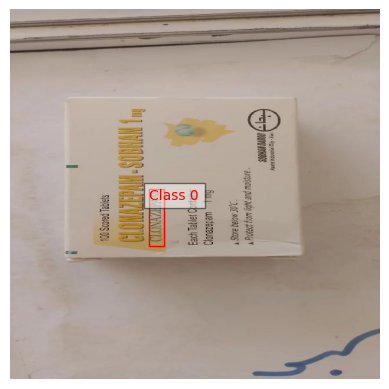

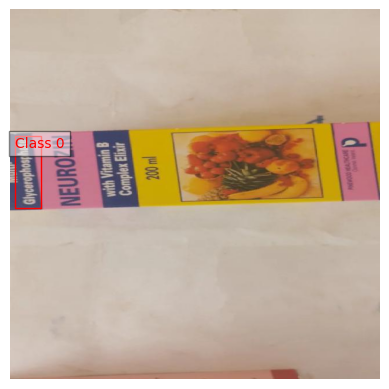

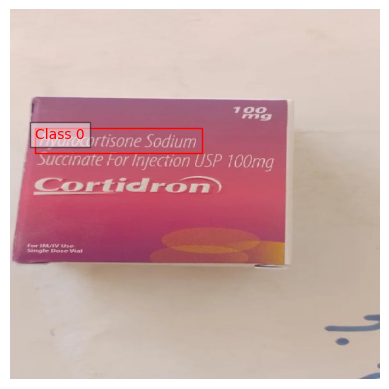

In [ ]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])

    # Draw bounding boxes using matplotlib
    plt.imshow(img[:, :, ::-1])  # Convert BGR to RGB
    plt.axis('off')

    for label in d['annotations']:
        bbox = label['bbox']
        category_id = label['category_id']
        x, y, w, h = bbox

        # Draw bounding box
        rect = plt.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

        # Add label if needed
        plt.text(x, y, f'Class {category_id}', color='r', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("drug_names",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class ("drug_name")
cfg.SOLVER.WARMUP_ITERS = 100  # Warm-up iterations for learning rate
cfg.SOLVER.GAMMA = 0.5  # Learning rate decay factor
cfg.TEST.EVAL_PERIOD = 500
cfg.SOLVER.OPTIMIZER = "ADAM"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/28 17:31:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 105MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/28 17:31:19 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/28 17:31:37 d2.utils.events]:  eta: 0:10:35  iter: 19  total_loss: 0.5073  loss_cls: 0.1885  loss_box_reg: 0.1153  loss_rpn_cls: 0.09439  loss_rpn_loc: 0.05008    time: 0.6581  last_time: 0.6087  data_time: 0.0473  last_data_time: 0.0568   lr: 0.0019081  max_mem: 3061M
[12/28 17:31:59 d2.utils.events]:  eta: 0:10:32  iter: 39  total_loss: 0.3506  loss_cls: 0.102  loss_box_reg: 0.1182  loss_rpn_cls: 0.0309  loss_rpn_loc: 0.051    time: 0.6704  last_time: 0.6019  data_time: 0.0477  last_data_time: 0.0307   lr: 0.0039061  max_mem: 3061M
[12/28 17:32:12 d2.utils.events]:  eta: 0:10:18  iter: 59  total_loss: 0.3216  loss_cls: 0.09657  loss_box_reg: 0.1159  loss_rpn_cls: 0.02124  loss_rpn_loc: 0.07055    time: 0.6569  last_time: 0.6302  data_time: 0.0271  last_data_time: 0.0369   lr: 0.0059041  max_mem: 3061M
[12/28 17:32:24 d2.utils.events]:  eta: 0:10:02  iter: 79  total_loss: 0.2813  loss_cls: 0.08924  loss_box_reg: 0.1105  loss_rpn_cls: 0.01267  loss_rpn_loc: 0.04029    time: 0.6477 

In [ ]:
# Evaluation on the validation set
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("drug_names",)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8

[12/28 17:42:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


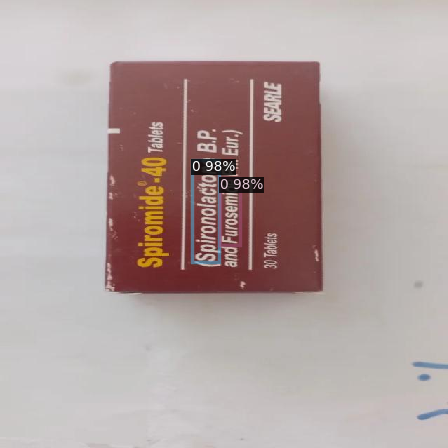

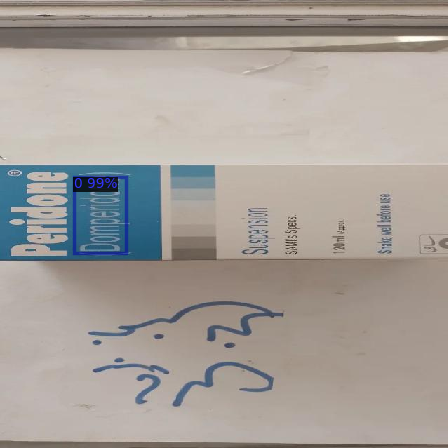

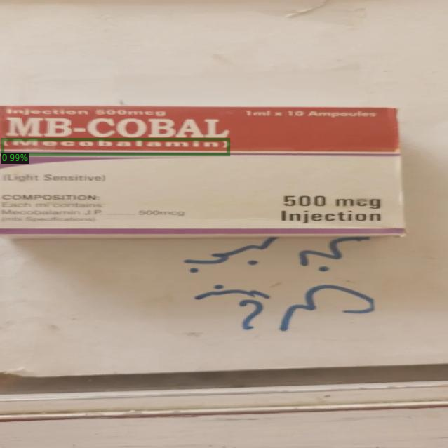

In [ ]:

# Inference and visualization (same as before)
predictor = DefaultPredictor(cfg)
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("coco_dataset"),
                   scale=0.7)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


In [ ]:
evaluator = COCOEvaluator("drug_names", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "drug_names")
print(inference_on_dataset(trainer.model, val_loader, evaluator))


[12/28 17:42:45 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/28 17:42:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/28 17:42:45 d2.evaluation.coco_evaluation]: Trying to convert 'drug_names' to COCO format ...
[12/28 17:42:45 d2.data.datasets.coco]: Converting annotations of dataset 'drug_names' to COCO format ...)
[12/28 17:42:46 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[12/28 17:42:46 d2.data.datasets.coco]: Conversion finished, #images: 251, #annotations: 280
[12/28 17:42:46 d2.data.datasets.coco]: Caching COCO format annotations at './output/drug_names_coco_format.json' ...
[12/28 17:42:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/28 17:42:46 d2.data.common]: Seriali

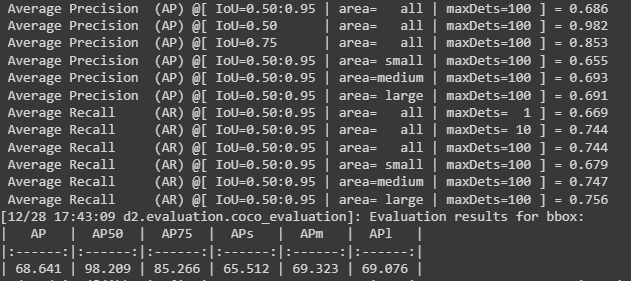

#Save Detrectron2 model

In [ ]:
with open("/content/drive/MyDrive/Dataset/config.yaml", "w") as f:
    f.write(cfg.dump())

In [ ]:
import shutil
shutil.copy("/content/output/model_final.pth", "/content/drive/MyDrive/Dataset/model_final.pth")

'/content/drive/MyDrive/Dataset/model_final.pth'